import pandas as pd

df = pd.read_excel('Asistencia_GS_Anual - copia.xlsx')

df = pd.melt(df, id_vars=['id_empleado', 'Nombre Operador'], var_name='Fecha', value_name='Asistencia')
#df.to_excel('xgboost.xlsx', index=False)



In [90]:
import pandas as pd

df = pd.read_csv('https://gist.githubusercontent.com/rafmirh/ba03eca41aa0d24671e1892b1b7deee2/raw/c77b0d346b17f425660243ab7f53680c9c27898b/gistfile1.txt')


In [91]:
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['DiaSemana'] = df['Fecha'].dt.weekday  # Día de la semana (lunes=0, domingo=6)
df['Dia'] = df['Fecha'].dt.day
df['Mes'] = df['Fecha'].dt.month
df['Año'] = df['Fecha'].dt.year

df

,id_empleado,Fecha,Tienda,Asistencia,DiaSemana,Dia,Mes,Año
0,1,2024-10-01,924242,1,1,1,10,2024
1,2,2024-10-01,921012,1,1,1,10,2024
2,3,2024-10-01,929187,1,1,1,10,2024
3,4,2024-10-01,926282,0,1,1,10,2024
4,5,2024-10-01,922435,1,1,1,10,2024
...,...,...,...,...,...,...,...,...
41435,588,2024-12-09,928415,1,0,9,12,2024
41436,589,2024-12-09,929859,1,0,9,12,2024
41437,590,2024-12-09,925270,1,0,9,12,2024
41438,591,2024-12-09,926182,1,0,9,12,2024


In [92]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41440 entries, 0 to 41439
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id_empleado  41440 non-null  int64         
 1   Fecha        41440 non-null  datetime64[ns]
 2   Tienda       41440 non-null  int64         
 3   Asistencia   41440 non-null  int64         
 4   DiaSemana    41440 non-null  int32         
 5   Dia          41440 non-null  int32         
 6   Mes          41440 non-null  int32         
 7   Año          41440 non-null  int32         
dtypes: datetime64[ns](1), int32(4), int64(3)
memory usage: 1.9 MB


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\gfdc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:26:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores parámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
Accuracy: 0.8407335907335908
              precision    recall  f1-score   support

           0       0.85      0.45      0.59      2106
           1       0.84      0.97      0.90      6182

    accuracy                           0.84      8288
   macro avg       0.85      0.71      0.75      8288
weighted avg       0.84      0.84      0.82      8288



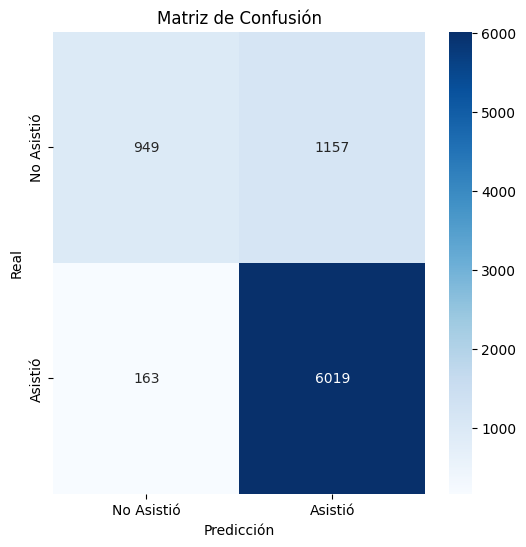

AUC-ROC: 0.8775506379302346


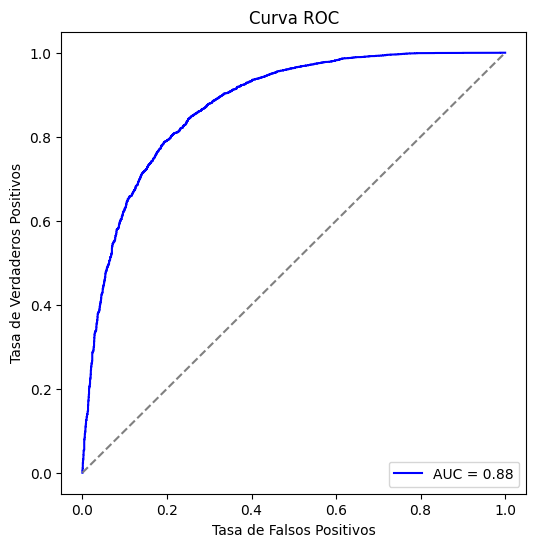

In [93]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Ecodeamos empleado y tienda 
le_empleado = LabelEncoder()
le_tienda = LabelEncoder()

df['id_empleado'] = le_empleado.fit_transform(df['id_empleado'])
df['Tienda'] = le_tienda.fit_transform(df['Tienda'])

# Se definen las características (X) y la variable objetivo (y) donde asistencia = 1 es que sí fue la persona y asistencias = 0 es ausencia
X = df[['id_empleado', 'Tienda', 'DiaSemana', 'Dia', 'Mes', 'Año']]
y = df['Asistencia']

# Dividir en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir los parámetros para GridSearchCV para encontrar los mejores hiperparametros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Crear el modelo de XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Realizar la búsqueda de hiperparámetros con GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Se imprimen los mejores parámetros obtenidos con el gridsearch
print("Mejores parámetros:", grid_search.best_params_)

# Usar el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Realizar predicciones
y_pred = best_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

# Se crea un objeto visual para visualizar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Asistió', 'Asistió'], yticklabels=['No Asistió', 'Asistió'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# evaluación ROC-AUC (Curva de Característica Operativa del Receptor)
from sklearn.metrics import roc_auc_score, roc_curve

# Calcular AUC-ROC
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print(f"AUC-ROC: {roc_auc}")

# objeto visual para  la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()
